# Train val test split for contrastive learning

In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import reduce
import operator
from plotnine import *
from scipy.spatial.distance import cdist

In [2]:
path = "/p/project1/hai_fzj_bda/koenig8/ot/data/"
adata_st = sc.read_h5ad(os.path.join(path, "adata_st.h5ad"))
adata_histo = sc.read_h5ad(os.path.join(path, "adata_histo.h5ad"))
adata_st, adata_histo

(AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section', 'test_set', 'val_set', 'train_set'
     uns: 'neighbors', 'umap'
     obsm: 'X_umap', 'brain_area_onehot', 'brain_area_similarities', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 190659 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'in_sample', 'test_set', 'val_set', 'train_set'
     obsm: 'brain_area_onehot', 'brain_area_similarities', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords')

### Start by defining a test set as a box

In [13]:
df = adata_st.obs

x_range = df['x_st'].max() - df['x_st'].min()
y_range = df['y_st'].max() - df['y_st'].min()
z_range = df['z_st'].max() - df['z_st'].min()
x_min = df['x_st'].min()
y_min = df['y_st'].min()
z_min = df['z_st'].min()
x_mid = x_min + x_range * 0.5
y_mid = y_min + y_range * 0.5
z_mid = z_min + z_range * 0.5

print(x_range, y_range, z_range)
print(x_mid, y_mid, z_mid)

12.082389225 7.3302377 5.31735195
6.5811633875 3.839345325 3.2162535


In [14]:
test_conditions = [
    (df['x_st'].between(x_mid - x_range * 0.2, x_mid + x_range * 0.2)) & 
    (df['y_st'].between(y_mid - y_range * 0.2, y_mid + y_range * 0.2)) & 
    (df['z_st'].between(z_min, z_min +  z_range * 0.3)) for df in (adata_st.obs, adata_histo.obs)
]
[(cond.sum(), cond.shape[0]) for cond in test_conditions]

[(np.int64(5503), 50000), (np.int64(7654), 190659)]

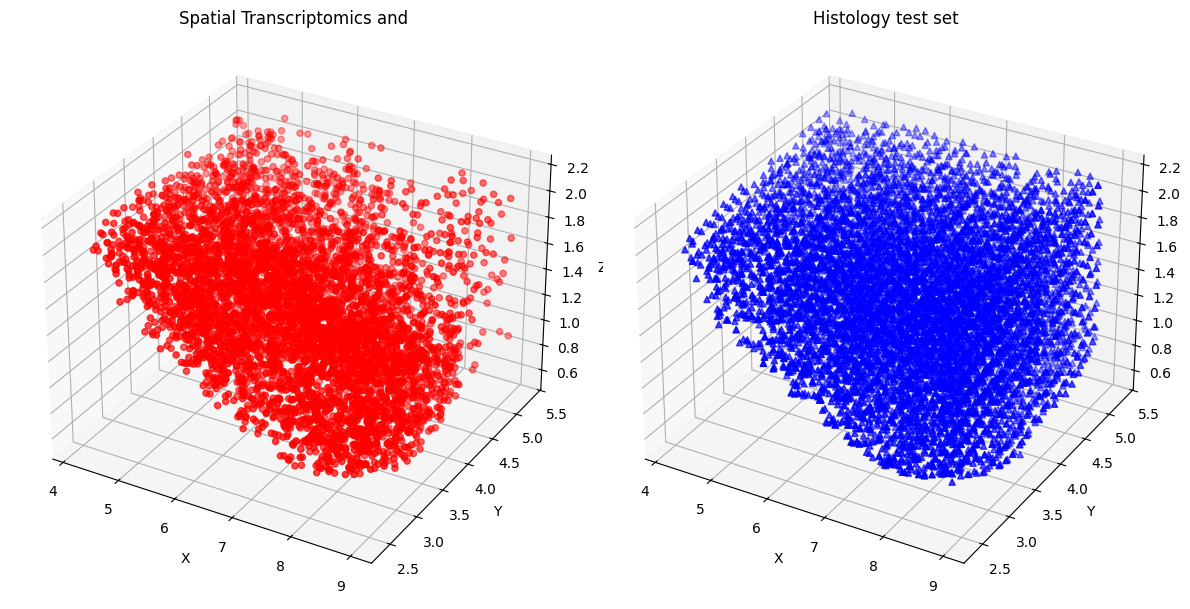

In [15]:
# Assign in the dataframes
adata_st.obs["test_set"] = False
adata_st.obs.loc[test_conditions[0], "test_set"] = True
adata_histo.obs["test_set"] = False
adata_histo.obs.loc[test_conditions[1], "test_set"] = True

fig = plt.figure(figsize=(12, 6))

# First subplot for df1
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
df1 = adata_st.obs[test_conditions[0]]
ax1.scatter(df1['x_st'], df1['y_st'], df1['z_st'], c='red', marker='o')
ax1.set_title('Spatial Transcriptomics and')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Second subplot for df2
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
df2 = adata_histo.obs[test_conditions[1]]
ax2.scatter(df2['x_st'], df2['y_st'], df2['z_st'], c='blue', marker='^')
ax2.set_title('Histology test set')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

In [16]:
df2["x_st"].min()

np.float64(4.169900516613812)

### Now continue by picking out slides for spatial transcriptomics validation set

In [17]:
set(adata_st.obs["brain_section_label"].unique()) == set(adata_st.obs.loc[~test_conditions[0], "brain_section_label"].unique())

True

==> All slides are still present in the remaining set

In [37]:
# Use ervery 6th slide for validation
val_slides = list(adata_st.obs["brain_section_label"].unique()[0::6])  # 129 total slides
print(val_slides)

# Annotate it in the spatial adata 
adata_st.obs["val_set"] = False
adata_st.obs.loc[adata_st.obs["brain_section_label"].isin(val_slides), "val_set"] = True

# Get the same x coordinates for the histo set, and make sure we dont let patches overlap
boundaries = [(adata_st.obs.loc[adata_st.obs["brain_section_label"] == slide, "x_st"].min(),# - 0.768/2, 
               adata_st.obs.loc[adata_st.obs["brain_section_label"] == slide, "x_st"].max(),# + 0.768/2,
               adata_st.obs.loc[adata_st.obs["brain_section_label"] == slide, "y_st"].min(),# - 0.768/2, 
               adata_st.obs.loc[adata_st.obs["brain_section_label"] == slide, "y_st"].max(),# + 0.768/2,
               adata_st.obs.loc[adata_st.obs["brain_section_label"] == slide, "z_st"].min(),# - 0.768/2, 
               adata_st.obs.loc[adata_st.obs["brain_section_label"] == slide, "z_st"].max())# + 0.768/2) 
              for slide in val_slides]
[(b[1] - b[0]) * (b[3] - b[2]) * (b[5] - b[4])  for b in boundaries]

['Zhuang-ABCA-1.079', 'Zhuang-ABCA-1.059', 'Zhuang-ABCA-1.041', 'Zhuang-ABCA-1.043', 'Zhuang-ABCA-1.097', 'Zhuang-ABCA-1.103', 'Zhuang-ABCA-1.037', 'Zhuang-ABCA-1.071', 'Zhuang-ABCA-1.066', 'Zhuang-ABCA-1.038', 'Zhuang-ABCA-1.110', 'Zhuang-ABCA-1.104', 'Zhuang-ABCA-1.108', 'Zhuang-ABCA-1.036', 'Zhuang-ABCA-1.027', 'Zhuang-ABCA-1.125', 'Zhuang-ABCA-1.137', 'Zhuang-ABCA-1.017', 'Zhuang-ABCA-1.124', 'Zhuang-ABCA-1.138', 'Zhuang-ABCA-1.118', 'Zhuang-ABCA-1.024']


[np.float64(17.452856908358882),
 np.float64(5.499383198129223),
 np.float64(1.9203601203046685),
 np.float64(2.339341485874477),
 np.float64(8.691129553414235),
 np.float64(10.757510542692685),
 np.float64(1.0912967510707081),
 np.float64(12.059479194725636),
 np.float64(9.671998851401943),
 np.float64(1.4516622124815022),
 np.float64(9.932414734652404),
 np.float64(11.359663132585569),
 np.float64(10.740329850165175),
 np.float64(0.9042700663491249),
 np.float64(0.6372229195798254),
 np.float64(8.83775535632892),
 np.float64(6.528675518689173),
 np.float64(0.5496447143975641),
 np.float64(9.492213330572874),
 np.float64(5.538825547859701),
 np.float64(7.782594028786799),
 np.float64(0.437146706452598)]

In [67]:
df = adata_histo.obs
val_conditions = [
    (df['x_st'].between(b[0], b[1])) & 
    (df['y_st'].between(b[2], b[3])) & 
    (df['z_st'].between(b[4], b[5])) for b in boundaries
]
val_cond = reduce(operator.or_, val_conditions)
val_cond = val_cond & (~test_conditions[1])
val_cond.sum(), val_cond.shape[0]

(np.int64(36112), 190659)

In [68]:
# Annotate in the histo adata
adata_histo.obs["val_set"] = False
adata_histo.obs.loc[val_cond, "val_set"] = True

# this makes sure that the validation set does not overlap with the train set
dist = 0.768/2
boundaries_big = [(b[0] - dist, b[1] + dist, b[2] - dist, b[3] + dist, b[4] - dist, b[5] + dist) 
                    for b in boundaries]
boundaries_big = [[max(x, 0) for x in b] for b in boundaries_big]

train_conditions = [
    df['x_st'].between(b[0], b[1]) & 
    df['y_st'].between(b[2], b[3]) & 
    df['z_st'].between(b[4], b[5]) for b in boundaries_big
]
train_cond = ~reduce(operator.or_, train_conditions)
# Remove the test set from the train set
train_cond = train_cond & (~test_conditions[1])

adata_histo.obs["train_set"] = False
adata_histo.obs.loc[train_cond, "train_set"] = True
train_cond.sum(), train_cond.shape[0]

(np.int64(96517), 190659)

In [69]:
sums = adata_histo.obs.iloc[:, [-1, -2, -3]].sum(axis=1)
sums.value_counts()

1    140283
0     50376
Name: count, dtype: int64

In [78]:
# Annotate the train set
adata_st.obs["train_set"] = False
adata_st.obs.loc[~(test_conditions[0] | adata_st.obs["brain_section_label"].isin(val_slides)), "train_set"] = True
# Remove the test set from validation
adata_st.obs.loc[test_conditions[0], "val_set"] = False
adata_st.obs.iloc[:, [-1, -2, -3]].sum(axis=1).value_counts()

1    50000
Name: count, dtype: int64

### Visualize the val set

In [7]:
df_st = adata_st.obs.loc[:, ["x_st", "y_st", "z_st"]].copy()
df_histo = adata_histo.obs.loc[:, ["x_st", "y_st", "z_st"]].copy()


df_plot = pd.concat([
    df_histo[adata_histo.obs.val_set].assign(in_set = "val").assign(modality = "Histology"),
    df_histo[adata_histo.obs.test_set].assign(in_set = "test").assign(modality = "Histology"),
    df_histo[adata_histo.obs.train_set].assign(in_set = "train").assign(modality = "Histology"),
    df_st[adata_st.obs["val_set"]].assign(in_set = "val").assign(modality = "Spatial"),
    df_st[adata_st.obs["test_set"]].assign(in_set = "test").assign(modality = "Spatial"),
    df_st[adata_st.obs["train_set"]].assign(in_set = "train").assign(modality = "Spatial")
], ignore_index = True)

df_plot = pd.concat([
    df_plot.assign(x = df_plot["x_st"]).assign(y = df_plot["y_st"]).assign(view = "sagittal"),
    df_plot.assign(x = df_plot["y_st"]).assign(y = df_plot["z_st"]).assign(view = "coronal"),
], ignore_index = True).drop(columns= ["x_st", "y_st", "z_st"])

df_plot['set'] = pd.Categorical(
    df_plot['in_set'],
    categories=['test', 'val', 'train'],
    ordered=True
)

df_plot.shape

(380566, 6)

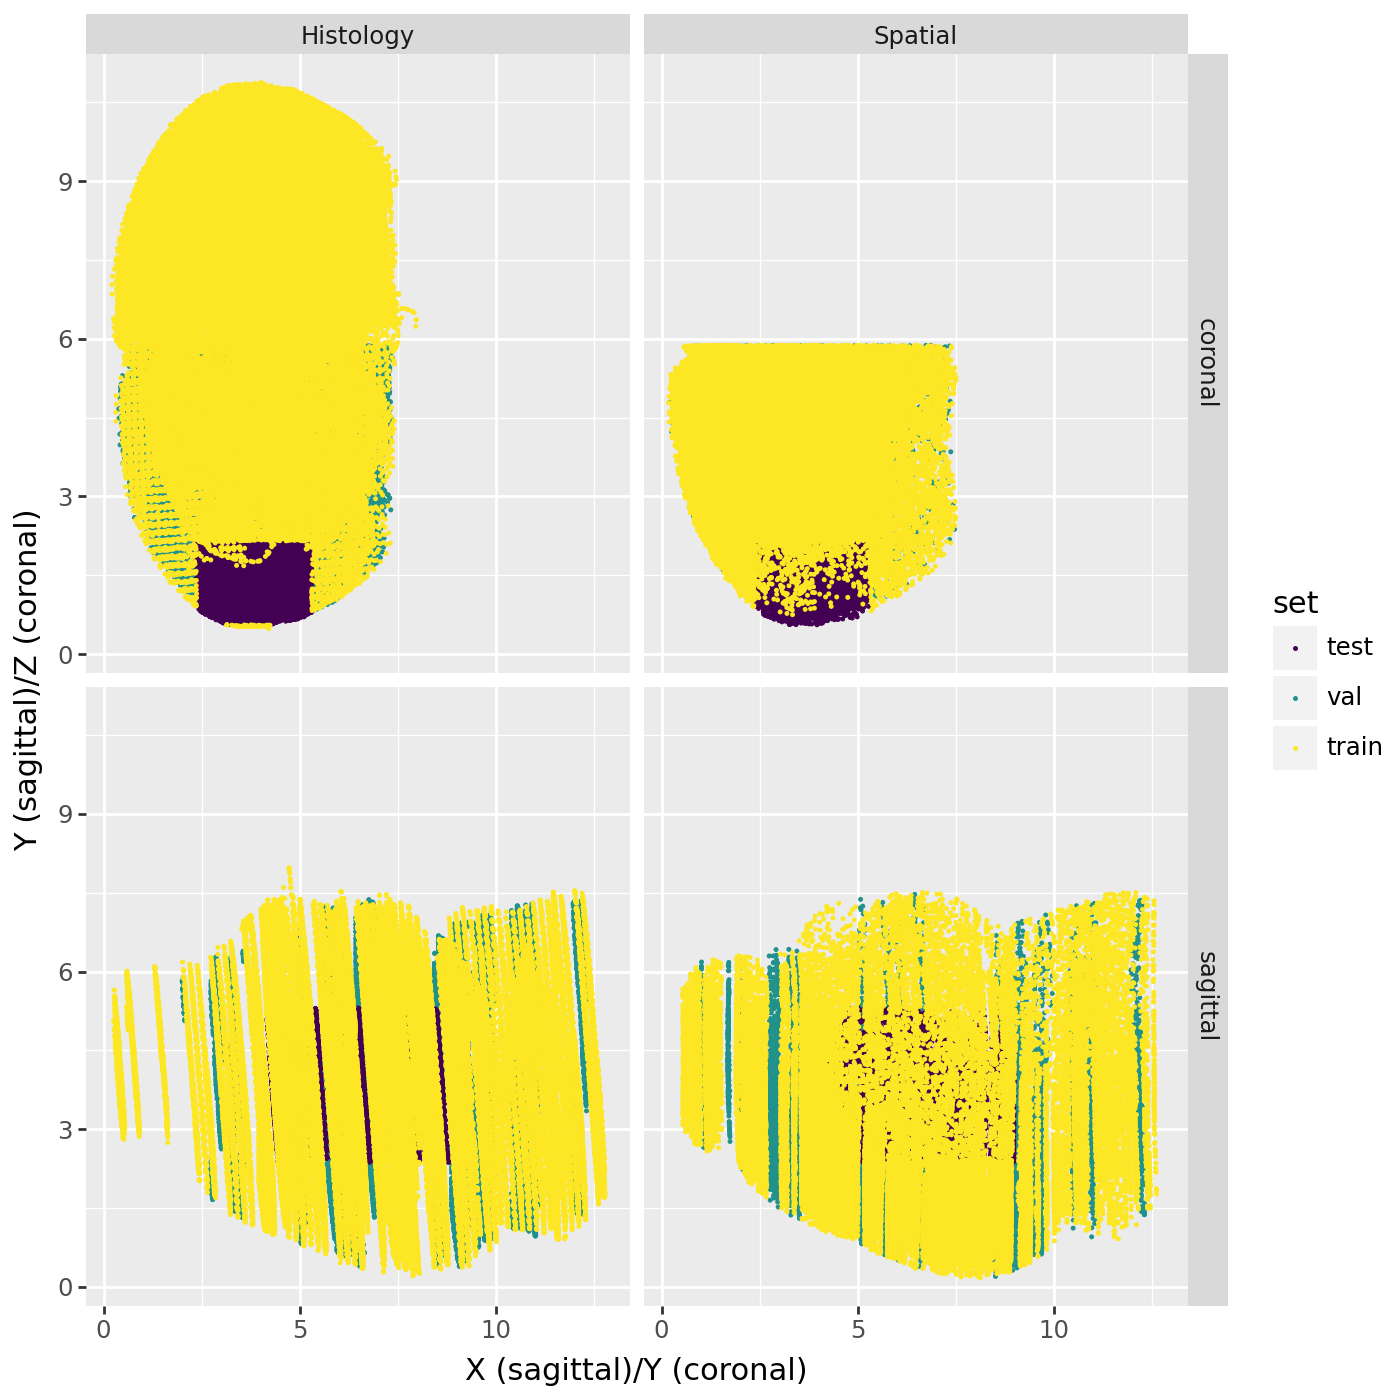

In [8]:
plot = (
    ggplot(df_plot, aes('x', 'y', color='set')) +
    geom_point(size = 0.01, alpha = 1.0) +
    facet_grid('view ~ modality') +
    labs(x = "X (sagittal)/Y (coronal)", y = "Y (sagittal)/Z (coronal)") + 
    theme(figure_size = (7, 7))
)
plot

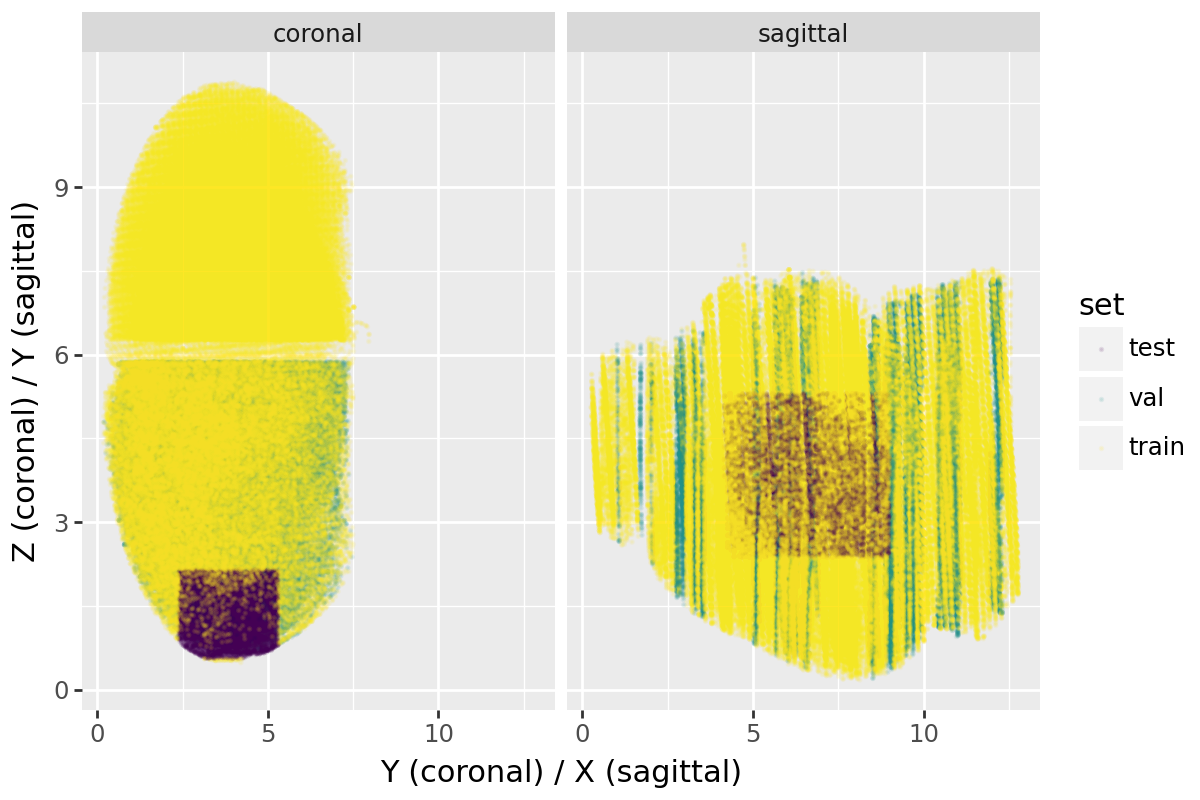

In [10]:
plot = (
    ggplot(df_plot, aes('x', 'y', color='set')) +
    geom_point(size = 0.1, alpha = 0.1) +
    facet_wrap('~ view') +
    labs(x = "Y (coronal) / X (sagittal)", y = "Z (coronal) / Y (sagittal)") + 
    theme(figure_size = (6,4))
)
plot

## Check for overlap between val and test in histo

In [90]:
dists = cdist(df_histo[val_cond], df_histo[train_cond], metric="euclidean")

min_dist = np.min(dists)
i, j = np.unravel_index(np.argmin(dists), dists.shape)

print(f"Minimum distance: {min_dist:.4f}")
df_histo[val_cond].iloc[i], df_histo[train_cond].iloc[j]

Minimum distance: 0.3880


(x_st    12.035433
 y_st     7.198494
 z_st     5.871450
 Name: 101445, dtype: float64,
 x_st    12.046228
 y_st     7.204343
 z_st     6.259261
 Name: 56018, dtype: float64)

==> Since the two closest samples are not closer than 768/2 microns to one another, there is no overlap

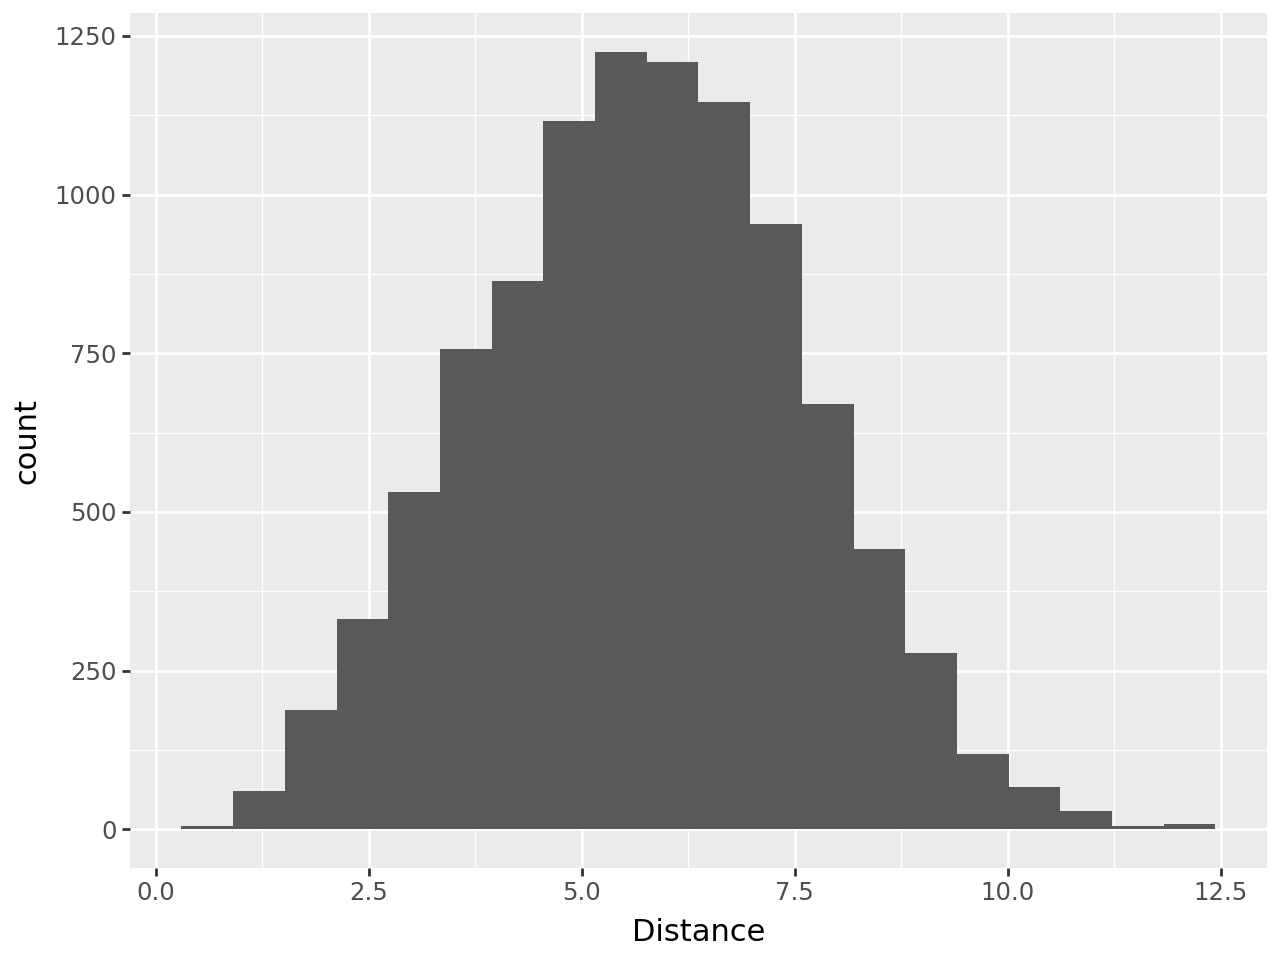

In [93]:
plot_df = pd.DataFrame(dists.flatten(), columns=["Distance",]).sample(n=10000)
ggplot(plot_df, aes(x="Distance")) + geom_histogram(bins=20)

## Save the adatas

In [87]:
adata_st.write_h5ad(os.path.join(path, "adata_st.h5ad"))
adata_histo.write_h5ad(os.path.join(path, "adata_histo.h5ad"))

### Look at brain areas across the splits

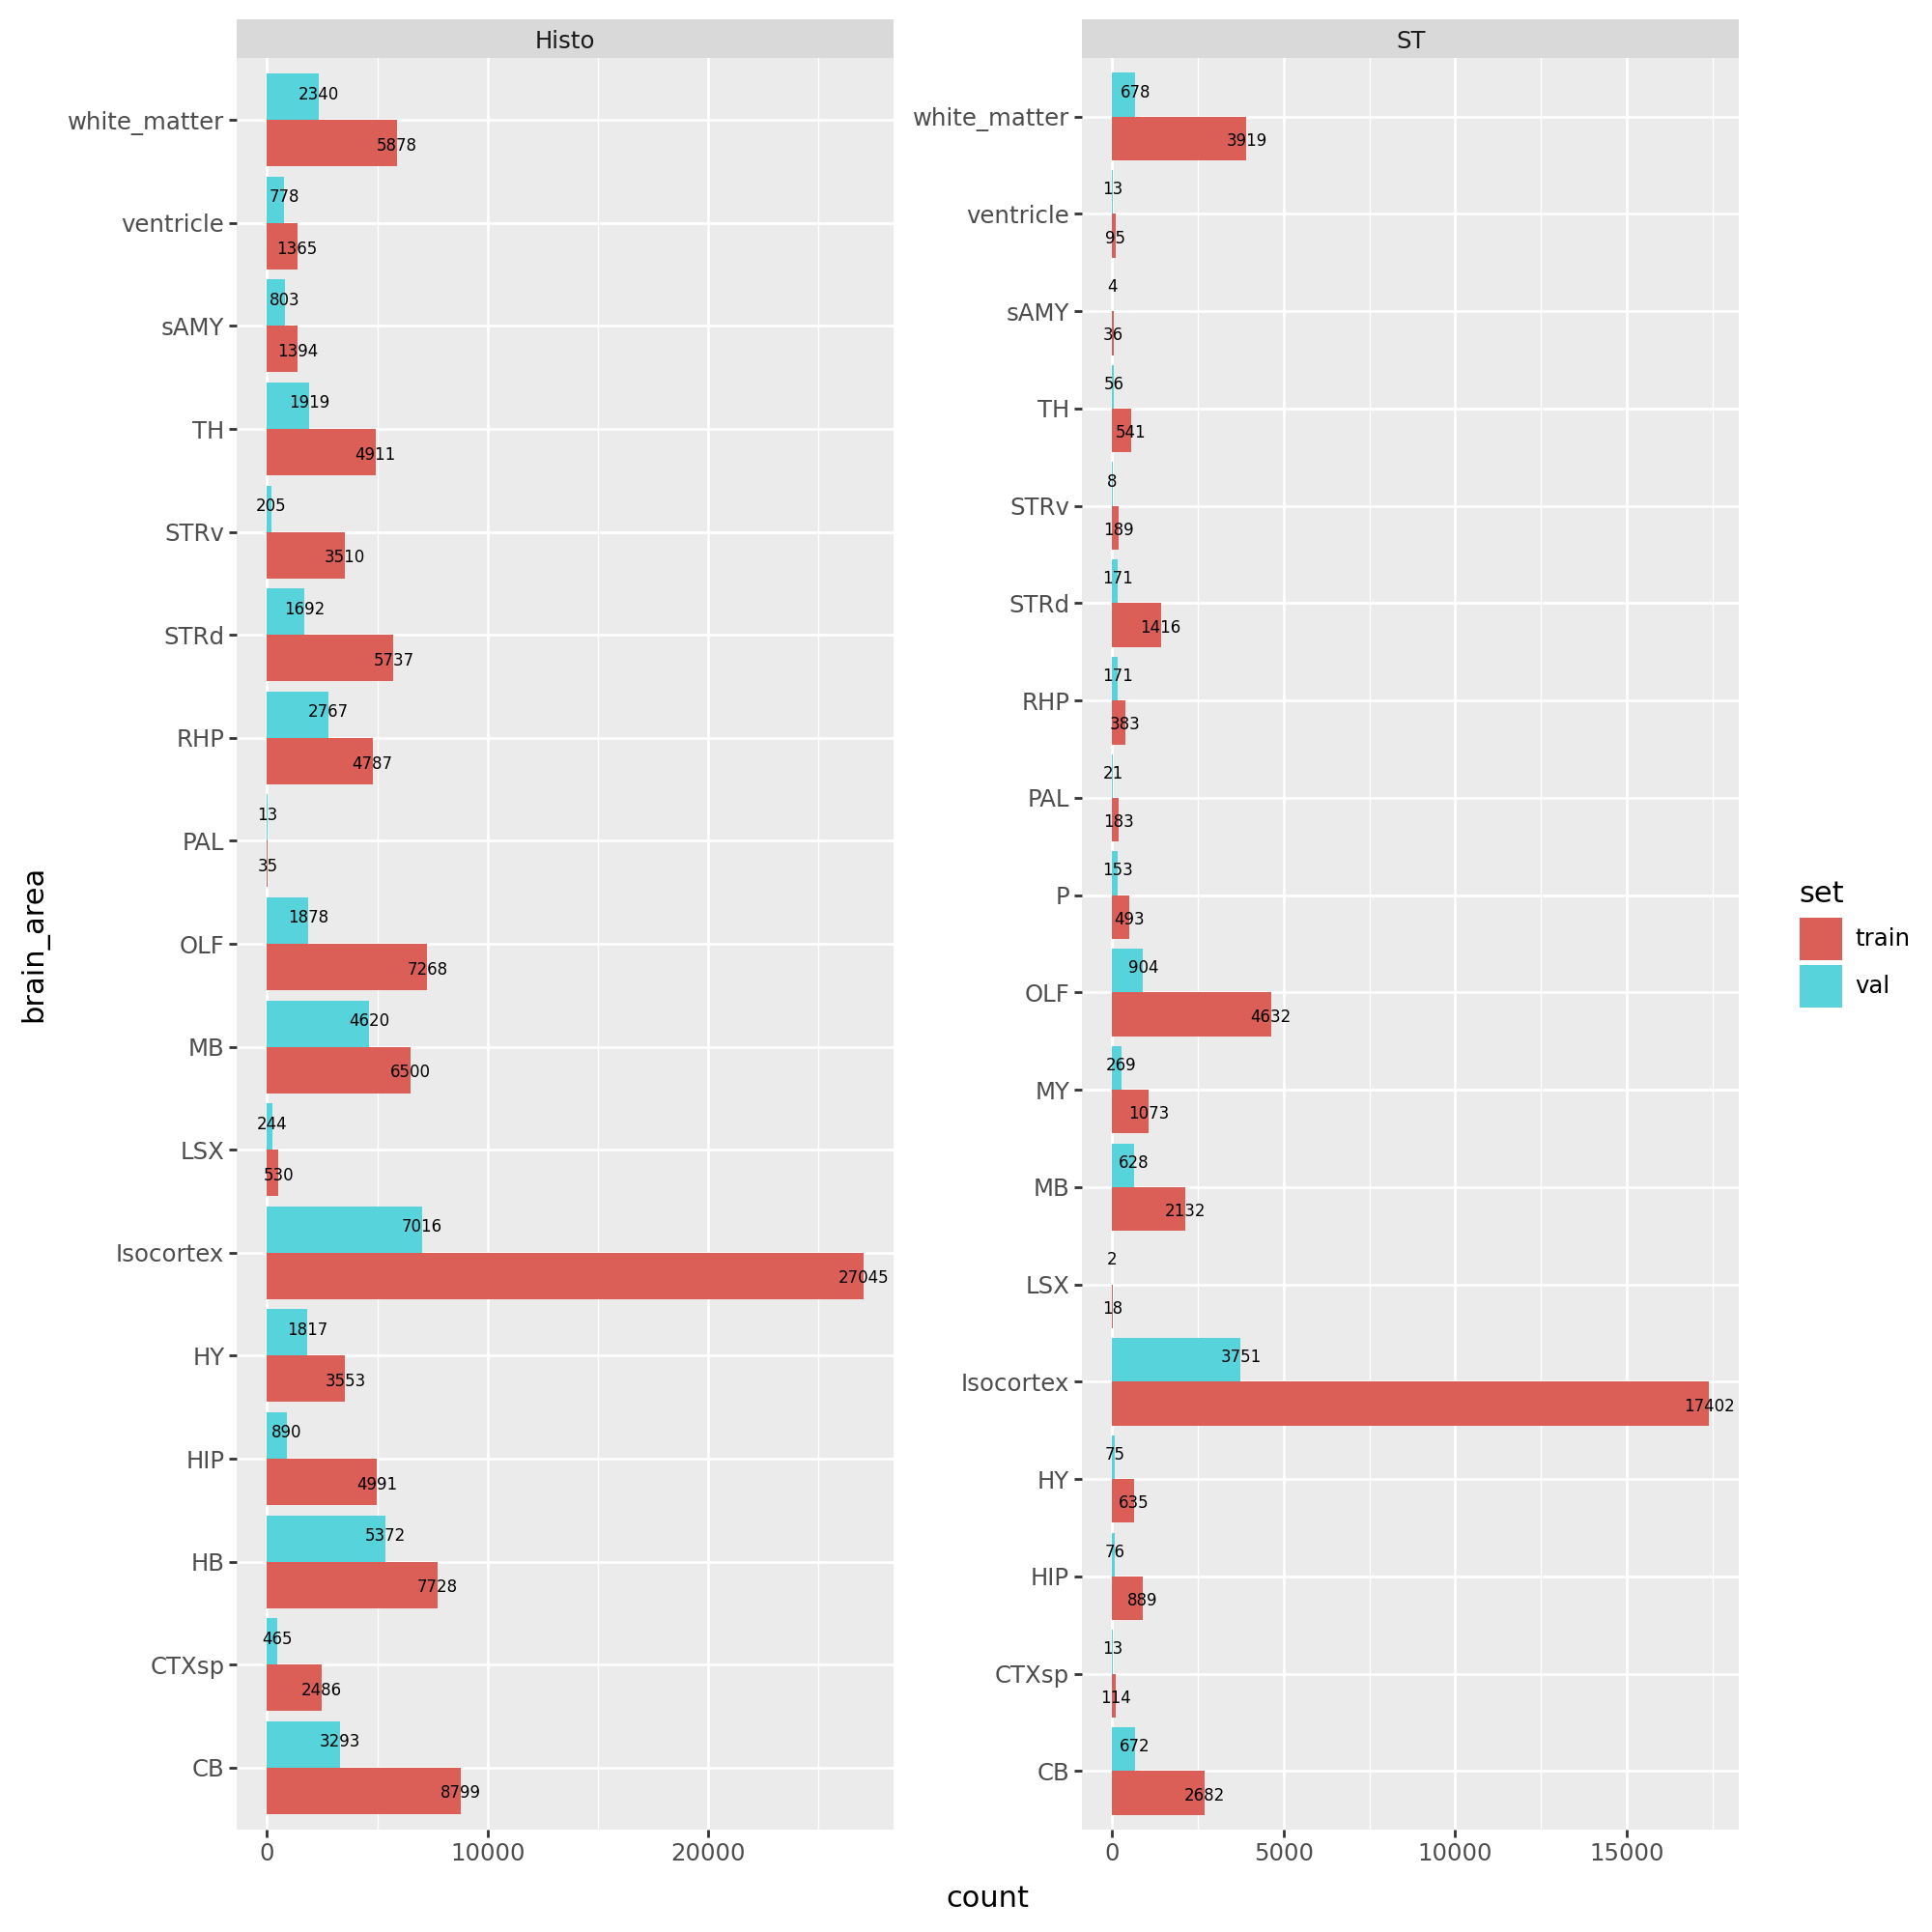

In [32]:
plot_frames = []
modalities = ("ST", "Histo")
c = 0
for ad in (adata_st, adata_histo):
    val_areas = ad.obs.loc[ad.obs.val_set, "brain_area"].value_counts()
    train_areas = ad.obs.loc[ad.obs.train_set, "brain_area"].value_counts()
    val_areas = pd.DataFrame(val_areas).reset_index().assign(set="val")
    train_areas = pd.DataFrame(train_areas).reset_index().assign(set="train")
    df = pd.concat((val_areas, train_areas), axis=0).assign(modality = modalities[c])
    #df["count"] = df["count"] / df["count"].sum()
    plot_frames.append(df)
    c += 1

plot_frames = pd.concat((plot_frames))
plot = (ggplot(plot_frames, aes(x = "brain_area", y="count", fill = "set", label="count")) + 
        geom_bar(stat="identity", position = "dodge") +
        geom_text(position=position_dodge(width = 1),  size=6) +
        facet_wrap("~ modality", scales="free")+
        coord_flip() +
        theme(figure_size=(10,10)))
plot

==> Val set represents the train set well in terms of brain areas. For st, a lot of areas have very few samples, especially in the val set. Maybe we should tweak the batch sizes for validation batches to include less per batch

In [34]:
plot_frames.loc[plot_frames.set == "val", "count"].sum() / plot_frames.loc[plot_frames.set == "train", "count"].sum() 

np.float64(0.328288926051189)

Validation is around 1/3 of the train set. Let's adapt n_pos and n_neg by this fraction